In [15]:
import pandas as pd
from astroquery.simbad import Simbad
from jwst import *

%load_ext autoreload
%autoreload 2


#assumes your target is in Tim Pearce's CSV File
target_name = 'HD61005'

df = pd.read_csv('../allDiscAnalysisResults.csv')
data_arr = df[['Target','Distance_pc','Age_Myr','PearceMPlt_MJup', 'PearcePltApocentre_arcsec','DiscInnerEdgePeri_au','DiscOuterEdgeApo_au']].to_numpy()
target_dict={}
for row in data_arr:
    target_dict[row[0]]=row[1:]

distance,age,planet_mass,separation,disk_inner_edge,disk_outer_edge = target_dict[target_name]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Query Simbad for Spectral type and K-mag

In [2]:
Simbad.add_votable_fields('flux(K)','sp')
result_table = Simbad.query_object(target_name)
kmag,spt = result_table['FLUX_K'][0], result_table['SP_TYPE'][0]

Query all targets to and force spectral types

In [3]:
targets=df['Target'].to_numpy()
queried_params=[];spts=[]
for target in targets:
    result_table = Simbad.query_object(target)
    spts.append(result_table['SP_TYPE'][0])
    queried_params.append([target,result_table['FLUX_K'][0]])

In [4]:
def match_spt(spt,lookuptable=lookuptable):
    available_keys=list(lookuptable.keys())
    matches=[];diffs=[]
    for key in available_keys:
        if spt[0]==key[0]:
            matches.append(key)
    for match in matches:
        diffs.append(np.abs(int(spt[1])-int(match[1])))
    forced_spt= spt[0] + str(matches[np.where(diffs==np.min(diffs))[0][0]])[1]+'V'
    return forced_spt

spts[40]='A5V'
spts[103]='A1V'
for i,spt in enumerate(spts):
    if spt not in lookuptable: 
        spts[i] = match_spt(spt)
[params.append(spts[i]) for i, params in  enumerate(queried_params)]

#adding another dictionary to hold these queried paramters in a more useful format
simbad_vals={}
for star in queried_params:
    simbad_vals[star[0]]=[star[1],star[2]]


In [5]:
instrument='nircam'
instrument_mask = 'mask335r'
jwst_filt = 'f444w'

kmag,spt = simbad_vals[target_name]

tst = get_jwst_mag(spt,kmag,instrument,jwst_filt,filter_dir="./",jwst_mask=instrument_mask,
                norm_filter='bessel_k')
print(tst)

6.459240137765576 VEGAMAG


In [6]:
filter_list = ['f250m','f300m','f356w','f410m','f444w','f1140c','f1550c']
instrument='nircam'
instrument_mask = 'mask335r'
jwst_filt = 'f444w'


configs = {'f250m':  {'instrument':'nircam','instrument_mask':'mask335r'},
            'f300m': {'instrument':'nircam','instrument_mask':'mask335r'}, 
            'f356w': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f410m': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f444w': {'instrument':'nircam','instrument_mask':'mask335r'},
            'f1140c':{'instrument':'miri',  'instrument_mask':None},
            'f1550c':{'instrument':'miri',  'instrument_mask':None},
            }
filter_list = list(configs.keys())

In [28]:
full_detection_list = []

for i, target in enumerate(targets):
    
    age = target_dict[target][1]
    distance = target_dict[target][0]
    comp_sep = target_dict[target][3] #Companion separation in arcseconds
    comp_mass = target_dict[target][2] #Companions mass in M_Jup

    disk_inner_edge = target_dict[target][4]/distance
    disk_outer_edge = target_dict[target][5]/distance
    
    kmag,spt = simbad_vals[target]
    
    mass_limits_list = []
    sep_list = []
    target_detection_array = []
    almost_detected_array = []

    print("Target: {}, {} Myr, {} pc, kmag={:.1f}".format(target,age,distance,kmag))

    if comp_sep < 0.3:
        print("\tCompanion separation for {} is < 0.3 arcseconds, skipping".format(target))
        continue

    for filter_name in filter_list:
        
        instrument = configs[filter_name]['instrument']
        instrument_mask = configs[filter_name]['instrument_mask']

        jwst_mag = get_jwst_mag(spt,kmag,instrument,filter_name,filter_dir="./",jwst_mask=instrument_mask,
                    norm_filter='bessel_k').value

        contrast_curves=read_contrast_curves()
        sep,companion_mags=companion_detection_limit(jwst_mag,filter_name,contrast_curves,plot=False);

        if comp_sep < np.min(sep):
            print("\tCompanion for {} is closer than the IWA in {}, skipping".format(target,filter_name))
            continue

        model_dir="/Users/maxwellmb/Data/ATMO2020/evolutionary_tracks/ATMO_CEQ/"
        model_dir+=model_instrument_directories.get(instrument.lower())
        
        if instrument.lower () == "nircam":
            model_dir+=model_nircam_mask_directories.get(instrument_mask.lower())


        mass_limits = generate_mass_curve(age,distance,companion_mags,filter_name,sep,model_dir,plot=False)

        detected = detect_companion(sep,mass_limits,comp_sep,comp_mass)
        target_detection_array.append(detected)

        #What if we got 2x deeper?
        almost_detected = detect_companion(sep,mass_limits/2.,comp_sep,comp_mass)
        almost_detected_array.append(almost_detected)

        # print("Was the companion detected? {}".format())
        mass_limits_list.append(mass_limits)
        sep_list.append(sep)

    if np.any(target_detection_array):
        print("\tCOMPANION DETECTED!")
        full_detection_list.append(True)
        figure_directory = "./Figures/Detected/"
    elif np.any(almost_detected_array): 
        full_detection_list.append(False)
        figure_directory = "./Figures/Almost_Detected/"
    else: 
        full_detection_list.append(False)
        figure_directory = "./Figures/Non-Detected/"
    
    fig,axis = plt.subplots(1,1,figsize=(12,5))
    for i in range(len(mass_limits_list)):
        plt.semilogy(sep_list[i],mass_limits_list[i],label=filter_list[i])
    plt.title("{}, {} Myr, {} pc, kmag={:.1f}, Detected: {}".format(target,age,distance,kmag,full_detection_list[-1]))
    plt.scatter(comp_sep,comp_mass,label="Predicted Companion")

    ymin, ymax = axis.get_ylim()

    plt.fill_between([disk_inner_edge,disk_outer_edge],[ymin],y2=[ymax],color='k',alpha=0.1)
    plt.xlabel("Separation (arcseconds)")
    plt.ylabel(r"Mass Limit ($M_{Jup}$)")
    plt.legend()
    plt.savefig(figure_directory+target+".png",dpi=200)
    plt.close()

        

Target: CD-522472, 50.0 Myr, 152.58 pc, kmag=8.7
	Companion separation for CD-522472 is < 0.3 arcseconds, skipping
Target: CPD-722713, 24.0 Myr, 36.62 pc, kmag=6.9
	COMPANION DETECTED!
Target: GJ581, 5000.0 Myr, 6.3 pc, kmag=5.8
	COMPANION DETECTED!
Target: GJ649, 4500.0 Myr, 10.38 pc, kmag=5.6
Target: HD166, 250.0 Myr, 13.77 pc, kmag=4.3
Target: HD203, 24.0 Myr, 39.91 pc, kmag=5.2
	Companion for HD203 is closer than the IWA in f1550c, skipping
Target: HD377, 220.0 Myr, 38.48 pc, kmag=6.1
Target: HD870, 3000.0 Myr, 20.62 pc, kmag=5.4
Target: HD1404, 450.0 Myr, 42.03 pc, kmag=4.4
Target: HD1461, 6000.0 Myr, 23.45 pc, kmag=4.9
Target: HD1466, 45.0 Myr, 42.92 pc, kmag=6.1
	Companion separation for HD1466 is < 0.3 arcseconds, skipping
Target: HD2262, 650.0 Myr, 22.25 pc, kmag=3.5
Target: HD3003, 45.0 Myr, 45.84 pc, kmag=5.0
	Companion for HD3003 is closer than the IWA in f1140c, skipping
	Companion for HD3003 is closer than the IWA in f1550c, skipping
Target: HD3296, 1400.0 Myr, 44.85 pc, 

In [21]:
disk_outer_edge

5.024576734025123

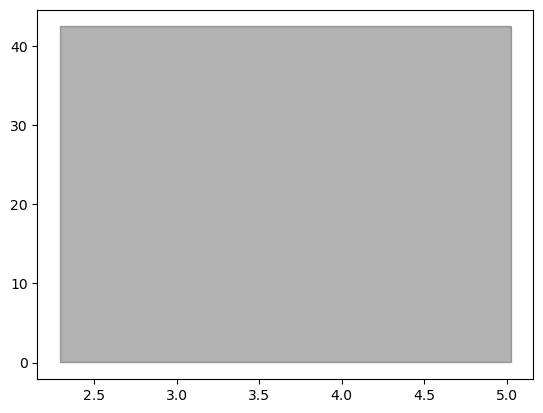

In [26]:
plt.fill_between([disk_inner_edge,disk_outer_edge],[ymin],y2=[ymax],color='k',alpha=0.3)

In [12]:
len(np.where(full_detection_list)[0])

20